**<u>Overview</u>**  
This notebook is a sample run through of the single cell transcriptomic analysis pipeline for the Tsai data. Note that while the entire pipeline is consolidated in this single notebook, in practice the pipeline will be run in chunks, and each chunk will utilize a different conda environment in accordance with the packages needed for that chunk. Additionally, it is important to note that all of the QC filtration will be run on a patient by patient basis, but all downstream steps will be run on all of the patients together (e.g data integration/batch correction will occur immediately following QC)

Here is a ***rough outline of the chunks***, and the respective conda environment needed for each chunk:
1. Quality Control
   1. *Environment*: ``/orcd/data/lhtsai/001/om2/mabdel03/conda_envs/qcEnv``
   2. *Purpose*: Remove high mitochondrial reads, high/low counts, and doublets
2. Data Integration + Batch Correction:
   1. *Environment*: ``/orcd/data/lhtsai/001/om2/mabdel03/conda_envs/``
   2. *Purpose*: Combine cells from all of the QC filtered patients into one AnnData object, removing batch effects (using patient as the batch variable)
3. Normalization + Feature Selection + Dimensionality Reduction + Clustering:
   1. *Environment*: ``/orcd/data/lhtsai/001/om2/mabdel03/conda_envs/``
   2. *Purpose*: Normalize counts, select highly variable feature, perform PCA/UMAP dimensionality reduction, and cluster
4. Cell Type Annotations:
   1. *Environment*: ``/orcd/data/lhtsai/001/om2/mabdel03/conda_envs/``
   2. *Purpose*: Annotate clusters with celltypes using marker genes
5. DEG Analysis:
   1. *Environment*: ``/orcd/data/lhtsai/001/om2/mabdel03/conda_envs/``
   2. *Purpose*: Identify differentially expressed genes using DEseq2 for pseudobulk DEG analysis

# Quality Control

In [2]:
import rpy2

ModuleNotFoundError: No module named 'rpy2'

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import scanpy as sc
from scipy.stats import median_abs_deviation
%load_ext rpy2.ipython

ModuleNotFoundError: No module named 'rpy2'

In [ ]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [24]:
root = '/orcd/data/lhtsai/001/om2/mabdel03/files/ACE_Analysis/Data/Tsai/Preprocessing/Preprocessed_Counts/ACE'
sub_1 = os.path.join(root, '23004922/processed_feature_bc_matrix_filtered.h5')
obj = sc.read_10x_h5(sub_1)

/orcd/data/lhtsai/001/om2/mabdel03/conda_envs/qcEnv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/orcd/data/lhtsai/001/om2/mabdel03/conda_envs/qcEnv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [25]:
obj.var_names_make_unique()

In [26]:
# mitochondrial genes
obj.var["mt"] = obj.var_names.str.startswith("MT-")
# ribosomal genes
obj.var["ribo"] = obj.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
obj.var["hb"] = obj.var_names.str.contains(("^HB[^(P)]"))

#Calculate the qc metrics
sc.pp.calculate_qc_metrics(obj, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)

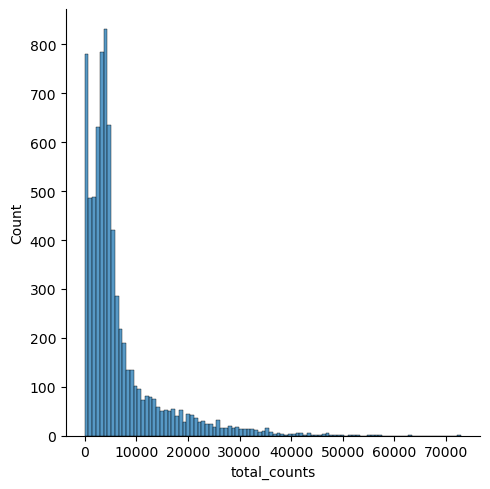

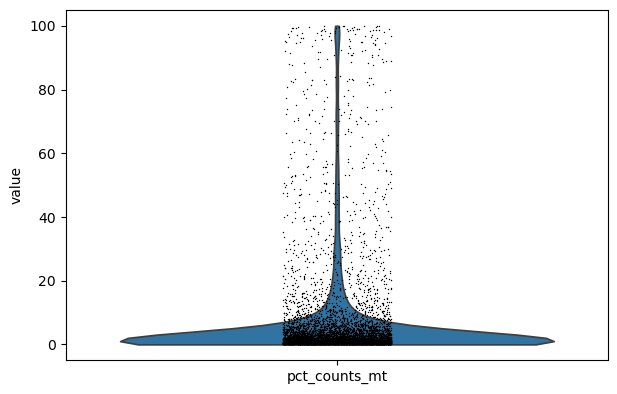

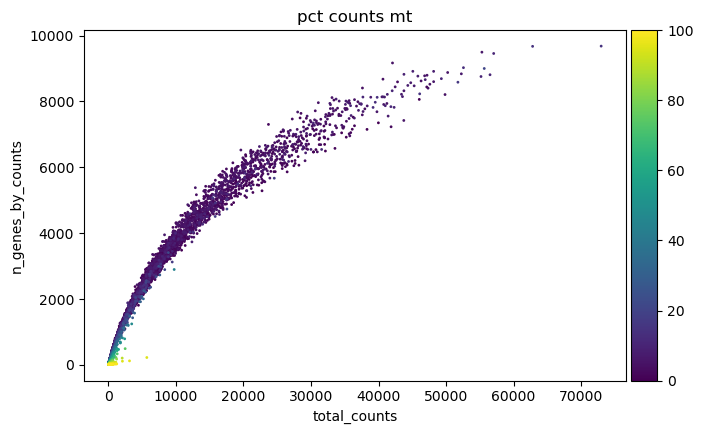

In [27]:
p1 = sns.displot(obj.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(obj, "pct_counts_mt")
p3 = sc.pl.scatter(obj, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [33]:
import matplotlib.pyplot as plt

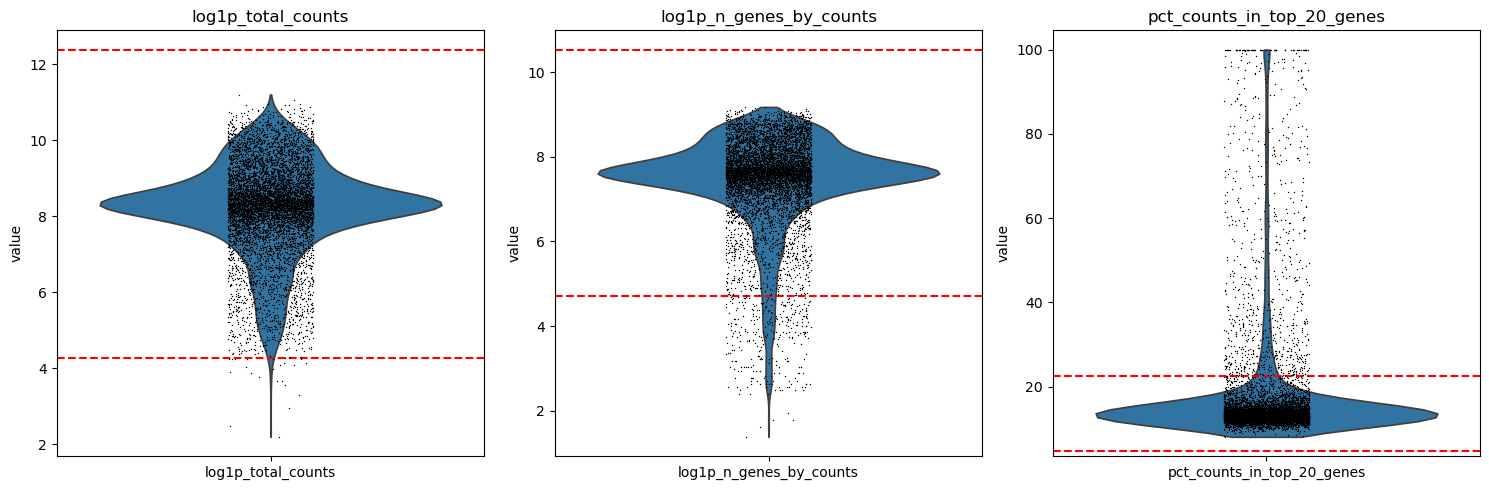

In [42]:
import scanpy as sc
import matplotlib.pyplot as plt

# Create a figure with 3 subplots (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: log1p_total_counts
sc.pl.violin(obj, "log1p_total_counts", ax=axs[0], show=False)
axs[0].axhline(y=4.277762161516291, color='red', linestyle='--')
axs[0].axhline(y=12.376481069183706, color='red', linestyle='--')
axs[0].set_title('log1p_total_counts')

# Plot 2: log1p_n_genes_by_counts
sc.pl.violin(obj, "log1p_n_genes_by_counts", ax=axs[1], show=False)
axs[1].axhline(y=4.715759053804929, color='red', linestyle='--')
axs[1].axhline(y=10.531524839218214, color='red', linestyle='--')
axs[1].set_title('log1p_n_genes_by_counts')

# Plot 3: pct_counts_in_top_20_genes
sc.pl.violin(obj, "pct_counts_in_top_20_genes", ax=axs[2], show=False)
axs[2].axhline(y=4.579817841985385, color='red', linestyle='--')
axs[2].axhline(y=22.559444888907354, color='red', linestyle='--')
axs[2].set_title('pct_counts_in_top_20_genes')

# Adjust layout
plt.tight_layout()

# Show the combined figure
plt.show()


In [29]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric] #pull column of values of interest (metric we are looking at)
    print(f'Lower Bound Outlier Threshod for {metric}: {np.median(M) - nmads * median_abs_deviation(M)}')
    print(f'Upper Bound Outlier Threshod for {metric}: {np.median(M) + nmads * median_abs_deviation(M)}')
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    ) # 'outliers' are are values who are plus or minus nmads (which we specify) from the median
    return outlier

In [41]:
# Add outlier status to every cell in every subject
#outlier status for non mito metrics --> use MAD for this
obj.obs["outlier"] = (
    is_outlier(obj, "log1p_total_counts", 7)
    | is_outlier(obj, "log1p_n_genes_by_counts", 7)
    | is_outlier(obj, "pct_counts_in_top_20_genes", 7)
)

#outlier status for mito metrics
#sc best practices included: is_outlier(obj, "pct_counts_mt", 3) | 
obj.obs["mt_outlier"] = obj.obs["pct_counts_mt"] > 10 #classify mitochondrial outliers as cells with >10 percent mito

Lower Bound Outlier Threshod for log1p_total_counts: 4.277762161516291
Upper Bound Outlier Threshod for log1p_total_counts: 12.376481069183706
Lower Bound Outlier Threshod for log1p_n_genes_by_counts: 4.715759053804929
Upper Bound Outlier Threshod for log1p_n_genes_by_counts: 10.531524839218214
Lower Bound Outlier Threshod for pct_counts_in_top_20_genes: 4.579817841985385
Upper Bound Outlier Threshod for pct_counts_in_top_20_genes: 22.559444888907354


In [47]:
len(obj.obs)

7446

In [48]:
obj.obs["mt_outlier"].sum()/7446

0.11791565941445072

Total number of cells: 7446
Number of cells after filtering of low quality cells: 6430


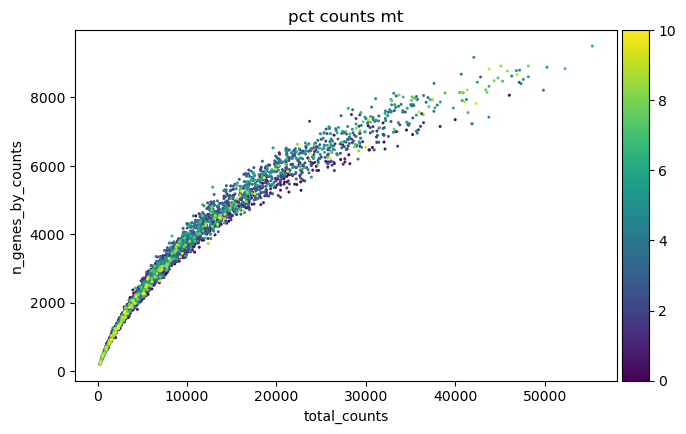

In [49]:
print(f"Total number of cells: {obj.n_obs}")
obj_1 = obj[(~obj.obs.outlier) & (~obj.obs.mt_outlier)].copy()
print(f"Number of cells after filtering of low quality cells: {obj_1.n_obs}")
p1 = sc.pl.scatter(obj_1, "total_counts", "n_genes_by_counts", color="pct_counts_mt") # make plots

## Doublet Removal

In [ ]:
import anndata
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
from rpy2.robjects.vectors import ListVector
import numpy as np

# Activate the automatic conversion between R and Python
numpy2ri.activate()
pandas2ri.activate()

# Assume `obj` is your AnnData object
data_mat = obj.X.T

# Import the necessary R packages
scDblFinder = importr('scDblFinder')
SingleCellExperiment = importr('SingleCellExperiment')

# Convert the data_mat to an R matrix
r_data_mat = ro.r.matrix(data_mat, nrow=data_mat.shape[0], ncol=data_mat.shape[1])

# Create SingleCellExperiment object
sce = SingleCellExperiment.SingleCellExperiment(ListVector({'counts': r_data_mat}))

# Run scDblFinder
ro.r('set.seed')(123)  # Set seed for reproducibility
sce = scDblFinder.scDblFinder(sce)

# Extract doublet scores and classes
doublet_score = ro.conversion.rpy2py(sce.slots['assays'].__getitem__('data').__getitem__('scDblFinder.score'))
doublet_class = ro.conversion.rpy2py(sce.slots['assays'].__getitem__('data').__getitem__('scDblFinder.class'))

# Assign doublet scores and classes to obj.obs
obj.obs["scDblFinder_score"] = doublet_score
obj.obs["scDblFinder_class"] = doublet_class

# Display value counts of doublet classes
print(obj.obs.scDblFinder_class.value_counts())